In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
sys.path.append(str(Path("..").resolve()))
from ast import literal_eval
from sdm import visualize_skillcorner as vsc
from sdm import visualize_features as vf
from IPython.display import HTML
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import os
from functools import partial
from sdm import visualize_features as vf
from unxpass.datasets import PassesDataset
from unxpass.components.withSpeeds import pass_selection_speeds, pass_value_speeds
import mlflow
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
diffs = pd.read_csv("/home/lz80/asi_goalkeeper_positioning/stores/frame_results.csv")
gks = diffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')

In [3]:
meta = pd.read_csv("/home/lz80/rdf/sp161/shared/asi_gk_pos/data/matches_meta.csv")

In [4]:
gks_l = meta['players'].apply(lambda x: {player['id'] : player['short_name'] for player in literal_eval(x) if player['player_role']['acronym'] == 'GK'})
from functools import reduce
big = reduce(lambda x, y: {**x, **y}, gks_l)

In [5]:
gks = gks.reset_index()
gks['name'] = gks['gk_id'].map(big)
gks[gks['count'] >= 1000].sort_values(by = "mean", ascending = False).head(5)

,gk_id,mean,count,name
23,57129,0.005700,10504,K. Lund
22,22829,0.005301,6321,A. Franch
21,634736,0.005170,1141,A. Anderson
19,151143,0.004979,1847,C. Miller
18,167381,0.004929,2468,L. Proulx


In [6]:
wyscout = pd.read_parquet("/home/lz80/rdf/sp161/shared/asi_gk_pos/data/wyscout_events_2026.parquet")

In [7]:
meta['date_time'] = pd.to_datetime(meta['date_time'])
cutoff = meta['date_time'].quantile(0.5)
meta['season_half'] = (meta['date_time'] > cutoff).map(
    {False: 'first', True: 'second'}
)

In [8]:
first_half = meta[meta['season_half'] == 'first']['id']
second_half = meta[meta['season_half'] == 'second']['id']
firstdiffs = diffs[diffs['match_id'].isin(first_half)]
seconddiffs = diffs[diffs['match_id'].isin(second_half)]

In [9]:
first_gk = firstdiffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')
second_gk = seconddiffs.groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')

In [10]:
merged = pd.merge(first_gk, second_gk, left_index = True, right_index = True)
merged
merged[["mean_x", "mean_y"]].corr()

,mean_x,mean_y
mean_x,1.000000,0.397349
mean_y,0.397349,1.000000


In [15]:
first_gk.shape[0], second_gk.shape[0]

(23, 17)

In [18]:
gks

,gk_id,mean,count,name
0,169916,-0.000121,690,C. Roque
1,151216,0.001347,660,H. Beall
2,22573,0.001420,1836,M. Arnold
3,151201,0.001534,10917,D. Haracic
4,151090,0.001700,9938,S. Hogan
5,151608,0.002003,3768,Laurel Ivory
6,177501,0.002560,12473,Mandy Haught
7,57139,0.002819,8057,K. Rowland
8,627213,0.002936,479,M. Wood
9,57092,0.002946,6836,A. Berger


In [17]:
merged

,mean_x,count_x,mean_y,count_y
gk_id,,,,
151090,0.002243,7699,-0.000168,2239
22573,0.002248,1017,0.000391,819
177501,0.002513,10183,0.002766,2290
151201,0.002514,8402,-0.001740,2515
57139,0.003382,5126,0.001835,2931
57092,0.003775,4196,0.001629,2640
57135,0.004099,7300,0.003279,2352
22734,0.004525,6218,0.001937,2059
151616,0.004712,4568,0.002419,2457


(-0.002757822483047056, 0.006296379495143189)

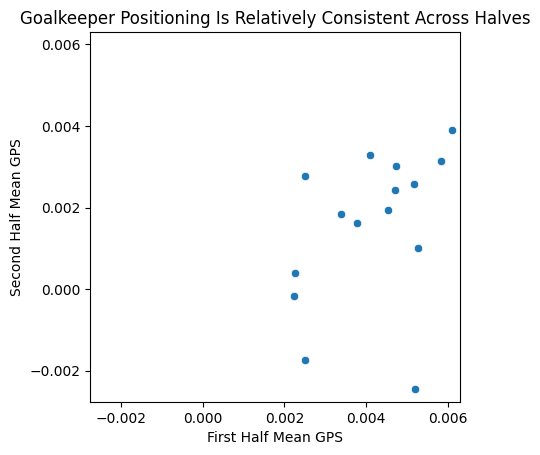

In [25]:
merged
import seaborn as sns
fig = sns.scatterplot(data=merged, x="mean_x", y="mean_y")
plt.title('Goalkeeper Positioning Is Relatively Consistent Across Halves')
plt.xlabel('First Half Mean GPS')
plt.ylabel('Second Half Mean GPS')

# Make plot square with equal scaling
ax = plt.gca()
ax.set_aspect('equal', 'box')

# Optional: force same limits on both axes
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
ax.set_xlim(lims)
ax.set_ylim(lims)


In [31]:
diffs['diff'].quantile(.10), diffs['diff'].quantile(.9)


(-0.01097008116203368, 0.02055080207464906)

In [68]:
wyscout['player_position'].unique()

<StringArray>
[   'LW',    'RW',  'RCMF',   'DMF',  'LCB3',  'RCB3',    'RB',   'RCB',
 'LCMF3',  'LCMF', 'RCMF3',    'CF',   'LB5',    'LB',    'GK',   'LCB',
    'SS',   'RB5',    'CB',   'LWB',   'RWB',  'LAMF',   'AMF',  'RDMF',
  'RAMF',  'LDMF',   'LWF',   'RWF']
Length: 28, dtype: string

In [138]:
wyscout[wyscout['type_primary'].isin(['shot', 'shot_againat'])][['type_primary', 'type_secondary']].head(50)
wyscout['gk_action'] = wyscout['type_secondary'].apply(lambda x: ( 'goal' in x ) or ('save' in x))

In [153]:
gks = wyscout[wyscout['player_position'] == 'GK'].groupby("sk_match_id")['sk_player_id'].agg('unique')
gks


sk_match_id
1448682    [151616.0, 62526.0, 633565.0]
1449178               [42800.0, 57135.0]
1455157               [42800.0, 57129.0]
1455423             [151090.0, 151143.0]
1459802               [22734.0, 22829.0]
                       ...              
2016340              [261931.0, 57081.0]
2016423               [68745.0, 22938.0]
2016424               [64003.0, 22709.0]
2016425               [70035.0, 62816.0]
2016426              [654389.0, 68732.0]
Name: sk_player_id, Length: 317, dtype: object

In [148]:
wyscout[(wyscout['gk_action'])]#['shot_xg'].unique()

,sk_match_id,wy_match_id,frame,is_matched,frame_tracking_data_available,is_matched_applicable,aerial_duel_first_touch,aerial_duel_height,aerial_duel_opponent_height,aerial_duel_opponent_id,...,type_primary,type_secondary,video_timestamp,possession_team_id_src,possession_src,possession_team_name_src,phase_of_play_name,controlled_phase_name,next_id,gk_action
196,1863388,5650426,25119,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,"[save, save_with_reflex]",2512.42464,1954,54,Aston Villa,Transition,<NA>,930251.0,True
240,1825119,5650411,4401,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot,"[goal, opportunity, touch_in_box]",440.492248,2038,12,Leicester City WFC,Controlled,Phase 3,654389.0,True
276,1863388,5650426,25325,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,"[save, save_with_reflex]",2532.943196,1954,54,Aston Villa,Controlled,Phase 1,64162.0,True
532,1863388,5650426,56776,False,True,True,<NA>,<NA>,<NA>,<NA>,...,shot,"[goal, opportunity, touch_in_box]",5678.059283,1945,132,Crystal Palace,Transition,<NA>,143929.0,True
995,1863388,5650426,27328,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,"[save, save_with_reflex]",2733.243909,1954,58,Aston Villa,Controlled,Phase 1,64158.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503411,1802045,5564466,25356,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,"[save, save_with_reflex]",2535.522187,75402,63,Bay,Controlled,Phase 1,57140.0,True
503464,1467682,5564293,9338,False,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,[save],933.783195,68121,18,Racing Louisville,Set Piece,<NA>,22746.0,True
503952,1514369,5564338,52898,True,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,[save],5289.954909,75402,124,Bay,Controlled,Phase 1,22676.0,True
504290,1531871,5564346,52397,False,True,True,<NA>,<NA>,<NA>,<NA>,...,shot_against,"[save, save_with_reflex]",5239.724219,28701,121,Houston Dash,Contested,<NA>,151605.0,True


In [108]:
diffs_match = diffs.groupby(["match_id", "gk_id"])['diff'].mean().reset_index()

<Axes: xlabel='frame', ylabel='diff'>

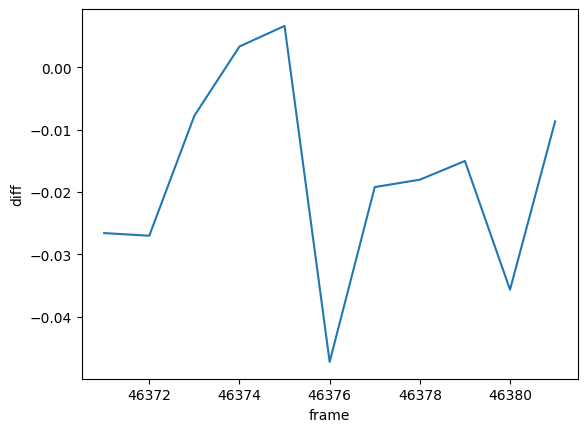

In [ ]:
poi_diffs = pd.read_csv("/home/lz80/asi_goalkeeper_positioning/stores/frame_results_po.csv")
poi = poi_diffs[poi_diffs['frame'] <= 46381]


In [100]:
diffs['diff_play'] = diffs['frame'] - 1 != diffs['frame'].shift(1)
diffs['play_id'] = diffs['diff_play'].cumsum() - 1
diffs

,match_id,frame,gk_id,expected,actual,diff,diff_play,play_id
0,1448682,120,62526,0.024577,0.021973,0.002604,True,0
1,1448682,121,62526,0.013473,0.017694,-0.004221,False,0
2,1448682,122,62526,-0.000258,0.010262,-0.010520,False,0
3,1448682,123,62526,0.008404,-0.007901,0.016305,False,0
4,1448682,124,62526,0.003405,0.000023,0.003382,False,0
...,...,...,...,...,...,...,...,...
151404,1875301,62223,149873,0.048106,0.030078,0.018028,True,7194
151405,1875301,62224,149873,0.031539,0.027934,0.003605,False,7194
151406,1875301,62225,149873,0.023320,0.009455,0.013865,False,7194
151407,1875301,62226,149873,0.011767,0.000390,0.011377,False,7194


In [158]:
plays =diffs.groupby("play_id")['diff', 'match_id', 'frame'].agg('mean').sort_values(by = 'diff').reset_index()

<positron-console-cell-158>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [ ]:
match, frame, play = plays[['match_id', 'frame', 'play_id']].iloc[12]
first_half = diffs[diffs['play_id'] == play].groupby("gk_id")['diff'].agg(['mean', 'count']).sort_values(by = 'mean')
second_half 


,match_id,frame,gk_id,expected,actual,diff,diff_play,play_id
65417,1573472,16628,151608,0.406469,0.492674,-0.086204,True,3123
65418,1573472,16629,151608,0.448595,0.518007,-0.069412,False,3123
65419,1573472,16630,151608,0.437303,0.530251,-0.092948,False,3123
65420,1573472,16631,151608,0.403932,0.509961,-0.106029,False,3123
65421,1573472,16632,151608,0.384976,0.502356,-0.117380,False,3123
65422,1573472,16633,151608,0.381436,0.472741,-0.091304,False,3123
65423,1573472,16634,151608,0.294456,0.384715,-0.090259,False,3123
65424,1573472,16635,151608,0.364614,0.473290,-0.108676,False,3123
65425,1573472,16636,151608,0.384614,0.496450,-0.111836,False,3123
65426,1573472,16637,151608,0.355736,0.467916,-0.112180,False,3123


[11/27/25 19:48:00] INFO     Animation.save using <class       ]8;id=945985;file:///home/lz80/.venv/lib/python3.10/site-packages/matplotlib/animation.py\animation.py]8;;\:]8;id=113656;file:///home/lz80/.venv/lib/python3.10/site-packages/matplotlib/animation.py#1052\1052]8;;\
                             'matplotlib.animation.HTMLWriter'                  
                             >                                                  


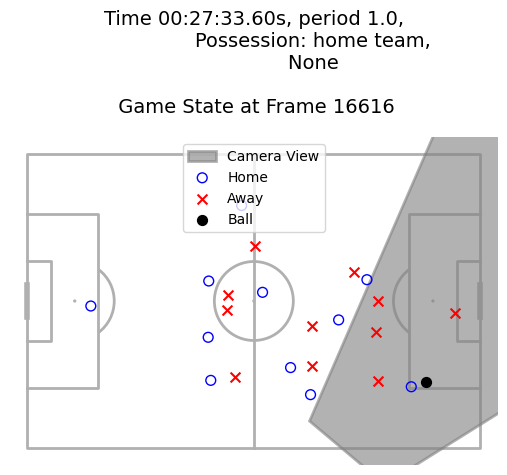

In [192]:
tracking = f"/home/lz80/rdf/sp161/shared/asi_gk_pos/data/tracking/{int(match)}_tracking.csv"
track_df = pd.read_csv(tracking)
home_team = vsc.get_players(match, meta)[0]
anim = vsc.animate_gamestate(track_df, range(int(frame - 20), int(frame + 20)), home_team)
HTML(anim.to_jshtml())

In [193]:
match
meta[meta['id'] == match]

,id,home_team_score,away_team_score,date_time,stadium,home_team,home_team_kit,away_team,away_team_kit,home_team_coach,...,competition_edition,match_periods,competition_round,referees,players,status,home_team_side,ball,pitch_length,pitch_width
188,1573472,5,2,2024-06-09T22:00:00Z,"{'id': 3140, 'name': 'CPKC Stadium', 'city': '...","{'id': 2329, 'name': 'Kansas City Current, Wom...","{'id': 8088, 'team_id': 2329, 'season': {'id':...","{'id': 2331, 'name': 'OL Reign FC, Women', 'sh...","{'id': 6555, 'team_id': 2331, 'season': {'id':...",NaN,...,"{'id': 800, 'competition': {'id': 126, 'area':...","[{'period': 1, 'name': 'period_1', 'start_fram...","{'id': 2294, 'name': 'Round 12', 'round_number...",[],"[{'player_role': {'id': 4, 'position_group': '...",closed,"['left_to_right', 'right_to_left']",{'trackable_object': 55},105,68


In [194]:
wy_events[(wy_events['sk_match_id'] == match) & (wy_events['frame'].between(frame - 50, frame + 50))][['type_primary', 'type_secondary', 'minute']]

,type_primary,type_secondary,minute
247282,shot_against,[conceded_goal],27
247763,shot,"[goal, opportunity, touch_in_box]",27
377681,pass,"[assist, deep_completion, key_pass, lateral_pa...",27


In [206]:


feats = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/feats"
end = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/poi"
for file in os.listdir(feats):
    df = pd.read_parquet(f"{feats}/{file}")
    df = df.loc[diffs[diffs['play_id'] == play][['match_id', 'frame']].values.tolist()]
    df.to_parquet(f"{end}/{file}")


In [ ]:
model_pass_selection = pass_selection_speeds.SoccerMapComponent(
        model=mlflow.pytorch.load_model(
            'runs:/ceea16e4a0254542bccf1f953f91381b/model', map_location='cpu'
        )
    )
OG_PATH = "/home/lz80/rdf/sp161/shared/asi_gk_pos/gk_pos_model/"
TEST = f"{OG_PATH}/test"
dataset_test = partial(PassesDataset, path=TEST)

ball_ff = pd.read_parquet(f"{TEST}/x_ball_freeze_frame.parquet")
ff = pd.read_parquet(f"{TEST}/x_player_freeze_frame.parquet")
value_features = pd.read_csv("/home/lz80/asi_goalkeeper_positioning/stores/value_features.csv").drop(columns = ['scores_xg'])

sel_surfaces = model_pass_selection.predict_surface(dataset_test)

[11/27/25 18:30:40] INFO     Loading dataset from                ]8;id=103362;file:///home/lz80/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=286816;file:///home/lz80/.venv/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\
                             /home/lz80/rdf/sp161/shared/asi_gk_                
                             pos/gk_pos_model/test                              


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:   1%|          | 9/1000 [00:00<00:26, 38.10it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Predicting DataLoader 0: 100%|██████████| 1000/1000 [00:23<00:00, 42.52it/s]


Text(0.5, 0.92, 'More Green Means Higher Probability')

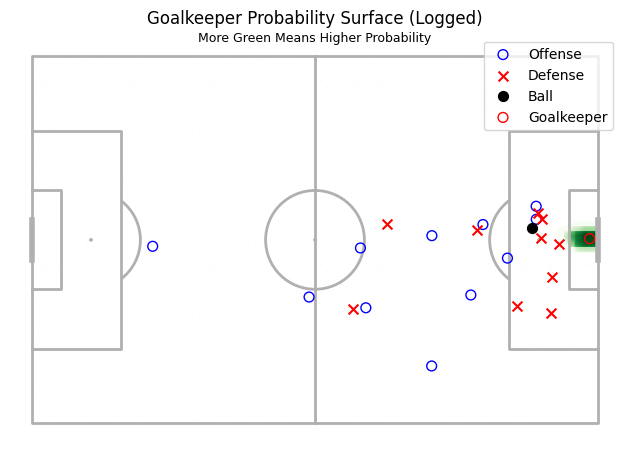

In [80]:
idx = ball_ff.index[12]

fig = vf.plot_from_features(idx, ff, ball_ff, sel_surfaces[idx[0]][idx[1]], log = True)
fig.suptitle("Goalkeeper Probability Surface (Logged)")
fig.text(0.5, 0.92, 'More Green Means Higher Probability', ha='center', va='center', fontsize=9)

In [55]:
poi

,match_id,frame,gk_id,expected,actual,diff,optimal
0,1836364,46371,654389,0.157299,0.183908,-0.026609,0.092238
1,1836364,46372,654389,0.177833,0.204863,-0.027031,0.112659
2,1836364,46373,654389,0.084981,0.092758,-0.007777,0.036074
3,1836364,46374,654389,0.103948,0.100621,0.003327,0.064789
4,1836364,46375,654389,0.195358,0.188730,0.006628,0.152495
5,1836364,46376,654389,0.203659,0.250936,-0.047277,0.137972
6,1836364,46377,654389,0.123288,0.142516,-0.019228,0.084246
7,1836364,46378,654389,0.083015,0.101054,-0.018039,0.056243
8,1836364,46379,654389,0.101396,0.116439,-0.015043,0.035725
9,1836364,46380,654389,0.136652,0.172341,-0.035689,0.086118
